# **Multi-Layer Perceptron (MLP)**

---

## **Introduction**

Multi-Layer Perceptron (MLP) is the simplest type of deep neural network, composed of fully connected layers. It operates on fixed-size vector inputs and is widely used in signal decoding, EEG classification, and regression tasks in Brain-Computer Interface (BCI) systems.

**Core ideas of MLP:**
- Fully Connected Architecture  
- Non-linear Transformations  
- End-to-End Learning of Input-Output Mapping  

---

## **Basic Structure**

An MLP maps input vector $x$ to output $y$ through stacked linear transformations and non-linear activations.

### (1) Single Hidden Layer MLP

$$
\begin{align}
h &= \phi(W_1 x + b_1) \quad \text{(Hidden Layer)} \\\\
y &= W_2 h + b_2 \quad \text{(Output Layer)}
\end{align}
$$

Where:
- $x \in \mathbb{R}^d$: input vector  
- $h \in \mathbb{R}^{d_h}$: hidden representation  
- $W_1$, $W_2$: learnable weights  
- $b_1$, $b_2$: biases  
- $\phi$: activation function (e.g., ReLU, Tanh)  

---

### (2) General Multi-Layer Form

For a network with $L$ hidden layers:

$$
h^{(0)} = x \\\\
h^{(l)} = \phi(W^{(l)} h^{(l-1)} + b^{(l)}), \quad l=1,...,L \\\\
y = W^{(out)} h^{(L)} + b^{(out)}
$$

---

## **Typical MLP Architecture**

Input EEG Vector (e.g., Flattened segment)  
→ Dense Layer + Activation  
→ Dropout / BatchNorm (optional)  
→ More Layers  
→ Output Layer (e.g., Regression or Softmax)

---

## **Advantages of MLP**

| Advantages | Description |
|------------|-------------|
| Simplicity | Easy to implement and fast to train |
| General Purpose | Works for various data types |
| Non-linear Mapping | Learns complex functions |
| Good Baseline | Often serves as a strong baseline for comparison |

---

## **Application Scenarios**

MLP is widely used in:

- EEG Signal Regression  
- Mental State Classification  
- Feature-Level Decoding  
- Early Prototyping in Deep Learning  
- Brain Signal-to-Command Mapping  

---

## **MLP in BCI**

### Typical Use Cases:
- Predicting continuous control variables from EEG  
- Classification of event-related EEG patterns  
- Quick prototyping for BCI pipelines  

### Advantages in BCI:
- Operates on flattened EEG feature vectors  
- Suitable for traditional CSP, PSD, or PCA features  
- Easy to implement, fast convergence  
- Serves as a strong baseline in EEG decoding  

---

## **Prerequisites**

- `numpy`  
- `torch`  
- `matplotlib`  
- `scikit-learn`  

---

MLPs are foundational models in deep learning and often combined with other modules in hybrid systems.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error

from utils import (
    load_data_model,
)

# load train and test data
data_dir = "../data/data_model/sub-jimingda/forward1.npz"
data_list = load_data_model(data_dir)
train_data, train_label = data_list["feature_train"], data_list["steering_train"]
test_data, test_label = data_list["feature_test"], data_list["steering_test"]

In [2]:
# DataLoader
train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32),
                              torch.tensor(train_label, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32),
                             torch.tensor(test_label, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
class EEG_MLP(nn.Module):
    def __init__(self, input_dim=63*200, hidden_dims=[512, 256, 64], dropout=0.3):
        super(EEG_MLP, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims

        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(dims[-1], 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (B, 63, 200)
        x = x.view(x.size(0), -1)
        out = self.network(x)
        return out.squeeze(1) 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
num_epochs = 10
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)

    epoch_loss /= len(train_loader)
    train_loss_list.append(epoch_loss)
    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

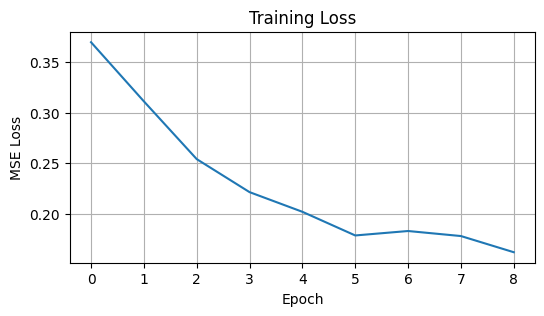

In [6]:
plt.figure(figsize=(6, 3))
plt.plot(train_loss_list[1:])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

In [7]:
model.eval()
predictions, targets_all = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        predictions.extend(outputs)
        targets_all.extend(targets.numpy())

mse = mean_squared_error(targets_all, predictions)
print(f"Test MSE: {mse:.4f}")

Test MSE: 0.0033


In [8]:
# plt.figure(figsize=(10, 4))
# plt.plot(predictions[1000:1500], label="Predicted")
# plt.plot(targets_all[1000:1500], label="True", alpha=0.7)
# plt.legend()
# plt.title("LSTM Prediction")
# plt.xlabel("Sample")
# plt.ylabel("Steering Angle")
# plt.tight_layout()
# plt.show()